In [1]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt

import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData

import os
import h5py

#import math
#import mpi4py.MPI as MPI
#print(MPI.Get_version())

In [2]:
def create_2D_mesh(nx, ny, x_start, x_end, y_start, y_end):
    """
    Creates a 2D mesh with the specified intervals and coordinate ranges.

    Args:
        nx (int): Number of intervals in the x-direction.
        ny (int): Number of intervals in the y-direction.
        x_start (float): Starting x-coordinate.
        x_end (float): Ending x-coordinate.
        y_start (float): Starting y-coordinate.
        y_end (float): Ending y-coordinate.

    Returns:
        mesh: The updated mesh with vertex coordinates set accordingly.
    """
    # Generate equally spaced coordinates for x and y
    x_coords = np.linspace(x_start, x_end, nx + 1)
    y_coords = np.linspace(y_start, y_end, ny + 1)
    
    # Create the mesh with initial x and y values set to 0 (they will be updated)
    mesh = mfem.Mesh(nx, ny, "QUADRILATERAL", True, 0.0, 0.0)
    
    # Retrieve the vertex array from the mesh
    verts = mesh.GetVertexArray()
    
    # Check if the number of vertices is as expected: (nx+1) * (ny+1)
    expected_num = (nx + 1) * (ny + 1)
    num_verts = mesh.GetNV()
    
    if num_verts != expected_num:
        print("Warning: Unexpected number of vertices! ({} != {})".format(num_verts, expected_num))
    
    # Update the vertex coordinates; vertices are stored in row-major order
    k = 0
    for j in range(ny + 1):
        for i in range(nx + 1):
            verts[k][0] = x_coords[i]
            verts[k][1] = y_coords[j]
            k += 1
    mesh.Print("output.mesh")

    return mesh

def gauss_legendre_dirs(N_dir):
    """Compute Gauss-Legendre quadrature points and weights for discrete ordinates.

    This function computes the Gauss-Legendre quadrature points (mu_i) and weights (w_i)
    for the specified number of discrete ordinates using NumPy's polynomial module.

    Args:
        N_dir (int): The number of discrete ordinates.

    Returns:
        tuple: A tuple containing two lists:
            - mu (list of float): The Gauss-Legendre quadrature points.
            - w (list of float): The corresponding Gauss-Legendre quadrature weights.
    """
    gg_mu, gg_w = np.polynomial.legendre.leggauss(N_dir)
    
    mu = gg_mu.tolist()
    w  = gg_w.tolist()
    
    return mu, w

def read_data(nE):
    """Read cross-section and stopping power data from an HDF5 file.

    This function reads data from the file "data.h5". It expects the following datasets:
      - "E_{nE}": Energy array.
      - "E_{nE}": Energy grid array.
      - "xs_t_{nE}": Total cross-section array.
      - "xs_s_{nE}": Scattering cross-section array.
      - "S_{nE}": Stopping power array.

    Args:
        nE (int): Number of energy groups.

    Returns:
        tuple: A tuple containing:
            - E_arr (numpy.ndarray): Energy array.
            - E_grid_arr (numpy.ndarray): Energy grid array.
            - xs_t_arr (numpy.ndarray): Total cross-section array.
            - xs_s_arr (numpy.ndarray): Scattering cross-section array.
            - S_arr (numpy.ndarray): Stopping power array.
    """
    data_file = "data.h5"

    with h5py.File(data_file, "r") as f:
        E_arr = f[f"E_{nE}"][:]
        E_grid_arr = f[f"E_grid_{nE}"][:]
        xs_t_arr = f[f"xs_t_{nE}"][:]
        xs_s_arr = f[f"xs_s_{nE}"][:]
        S_arr    = f[f"S_{nE}"][:]
        
    return E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr

class TotalXSCoefficient(mfem.PyCoefficient):
    """Coefficient for the total cross-section Σ_t(E).

    This coefficient maps the normalized energy coordinate (x[1]) in [0, 1] to the
    corresponding cross-section value. Specifically, a value of y = 0 corresponds to
    E = E_start and y = 1 corresponds to E = E_end.

    Attributes:
        xs_t_data (list or array-like): Total cross-section values for each energy group.
        E_start (float): The starting energy value.
        E_end (float): The ending energy value.
    """

    def __init__(self, xs_t_data, E_start, E_end):
        """Initializes the TotalXSCoefficient instance.

        Args:
            xs_t_data (list or array-like): Array containing the total cross-section values.
            E_start (float): Energy value corresponding to the start of the domain (y = 0).
            E_end (float): Energy value corresponding to the end of the domain (y = 1).
        """
        super(TotalXSCoefficient, self).__init__()
        self.xs_t_data = xs_t_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        """Evaluates the total cross-section at a given coordinate.

        This method converts the normalized energy coordinate found in x[1] to the actual 
        energy value and determines the corresponding energy group to return the associated 
        total cross-section value.

        Args:
            x (list or array-like): A coordinate array where x[1] is the normalized energy 
                (in the range [0, 1]).

        Returns:
            float: The total cross-section value corresponding to the computed energy.
        """
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.xs_t_data)
        group = min(n_groups - 1,
                    int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.xs_t_data[group])


class ScatteringXSCoefficient(mfem.PyCoefficient):
    """Coefficient for the scattering cross-section Σ_s(E).

    This coefficient maps the normalized energy coordinate (x[1]) in [0, 1] to the 
    corresponding scattering cross-section value. A value of y = 0 corresponds to E = E_start,
    and y = 1 corresponds to E = E_end.

    Attributes:
        xs_s_data (list or array-like): Array containing the scattering cross-section values.
        E_start (float): The starting energy value corresponding to y = 0.
        E_end (float): The ending energy value corresponding to y = 1.
    """

    def __init__(self, xs_s_data, E_start, E_end):
        """Initializes the ScatteringXSCoefficient instance.

        Args:
            xs_s_data (list or array-like): Array of scattering cross-section values.
            E_start (float): The starting energy value.
            E_end (float): The ending energy value.
        """
        super(ScatteringXSCoefficient, self).__init__()
        self.xs_s_data = xs_s_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        """Evaluates the scattering cross-section at a given normalized energy coordinate.

        This method converts the normalized energy coordinate from x[1] to an energy value
        and maps that to a corresponding energy group, returning the scattering cross-section 
        value from the xs_s_data array.

        Args:
            x (list or array-like): A coordinate array where x[1] is the normalized energy 
                in the range [0, 1].

        Returns:
            float: The scattering cross-section value for the computed energy.
        """
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.xs_s_data)
        group = min(n_groups - 1,
                    int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.xs_s_data[group])
 

class StoppingPowerCoefficient(mfem.PyCoefficient):
    """Coefficient for the stopping power S(E).

    This coefficient maps the normalized energy coordinate (x[1]) in the interval [0, 1]
    to the corresponding stopping power S(E). Specifically, a value of y = 0 corresponds to 
    E = E_start, and a value of y = 1 corresponds to E = E_end.

    Attributes:
        S_data (list or array-like): Array of stopping power values for each energy group.
        E_start (float): The starting energy value (corresponding to y = 0).
        E_end (float): The ending energy value (corresponding to y = 1).
    """

    def __init__(self, S_data, E_start, E_end):
        """Initializes the StoppingPowerCoefficient instance.

        Args:
            S_data (list or array-like): Array containing the stopping power values.
            E_start (float): The starting energy value.
            E_end (float): The ending energy value.
        """
        super(StoppingPowerCoefficient, self).__init__()
        self.S_data = S_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        """Evaluates the stopping power at a given normalized energy coordinate.

        Converts the normalized energy coordinate in x[1] to the actual energy value
        and retrieves the corresponding stopping power from S_data.

        Args:
            x (list or array-like): A coordinate array where x[1] is the normalized energy 
                (in the range [0, 1]).

        Returns:
            float: The stopping power value corresponding to the computed energy.
        """
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.S_data)
        group = min(n_groups - 1,
                    int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.S_data[group])

    
class StoppingPowerDerivativeCoefficient(mfem.PyCoefficient):
    """Coefficient for the derivative of the stopping power S(E), i.e., S'(E).

    This coefficient maps the normalized energy coordinate (x[1]) in the interval [0, 1]
    to the corresponding derivative of the stopping power S(E). A value of y = 0 corresponds 
    to E = E_start and y = 1 corresponds to E = E_end.

    Attributes:
        dS_data (list or array-like): Array containing the derivative values of the stopping power for each energy group.
        E_start (float): The starting energy value corresponding to y = 0.
        E_end (float): The ending energy value corresponding to y = 1.
    """

    def __init__(self, dS_data, E_start, E_end):
        """Initializes the StoppingPowerDerivativeCoefficient instance.

        Args:
            dS_data (list or array-like): Array containing the derivative values of the stopping power.
            E_start (float): The starting energy value.
            E_end (float): The ending energy value.
        """
        super(StoppingPowerDerivativeCoefficient, self).__init__()
        self.dS_data = dS_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        """Evaluates the derivative of the stopping power at a given normalized energy coordinate.

        This method converts the normalized energy coordinate in x[1] to the corresponding energy
        value and determines the appropriate energy group. It then returns the derivative value from
        the dS_data array corresponding to that energy group.

        Args:
            x (list or array-like): A coordinate array where x[1] is the normalized energy (in the range [0, 1]).

        Returns:
            float: The derivative of the stopping power corresponding to the computed energy.
        """
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.dS_data)
        group = min(n_groups - 1,
                    int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.dS_data[group])


class Inflow2DCoefficient(mfem.PyCoefficient):
    """Coefficient for the inflow boundary condition.

    Returns a prescribed inflow flux value.

    Attributes:
        inflow_value (float): The constant inflow flux value to be used.
    """

    def __init__(self, inflow_value):
        """Initializes the Inflow2DCoefficient with a given inflow flux value.

        Args:
            inflow_value (float): The inflow flux value that will be returned by EvalValue.
        """
        super(Inflow2DCoefficient, self).__init__()
        self.inflow_value = inflow_value

    def EvalValue(self, x):
        """Evaluates the inflow coefficient at a given coordinate.

        This method returns the prescribed constant inflow flux value, irrespective of the 
        input spatial coordinate.

        Args:
            x (iterable): The spatial coordinate (ignored in this coefficient).

        Returns:
            float: The prescribed inflow flux value.
        """
        return self.inflow_value


class QCoefficient(mfem.PyCoefficient):
    """Coefficient for the source term Q(x, E).

    This coefficient maps the normalized energy coordinate (x[1] in [0, 1]) to the corresponding
    source term Q value. Here, y = 0 corresponds to E = E_start and y = 1 corresponds to E = E_end.

    If Q_data is given as the scalar 0, then the coefficient always returns 0 and E_start and E_end are not required.
    """

    def __init__(self, Q_data, E_start=None, E_end=None):
        """Initializes the QCoefficient.

        Args:
            Q_data (int, float, or list): The source term data. If a scalar equal to 0 is provided, the
                coefficient will always return 0. Otherwise, if a nonzero scalar is provided, it is converted
                to a single-element list.
            E_start (float, optional): The starting energy value. Must be provided if Q_data is non-zero.
            E_end (float, optional): The ending energy value. Must be provided if Q_data is non-zero.

        Raises:
            ValueError: If non-zero Q_data is provided without both E_start and E_end.
        """
        super(QCoefficient, self).__init__()

        if isinstance(Q_data, (int, float)) and Q_data == 0:
            self.scalar_zero = True
            self.Q_data = None
        else:
            if E_start is None or E_end is None:
                raise ValueError("For non-zero Q_data, E_start and E_end must be provided.")
            self.scalar_zero = False
            if isinstance(Q_data, (int, float)):
                self.Q_data = [Q_data]
            else:
                self.Q_data = Q_data
            self.E_start = E_start
            self.E_end = E_end

    def EvalValue(self, x):
        """Evaluates the source term Q at a given coordinate.

        For a non-zero Q_data, this method converts the normalized energy coordinate x[1] to the corresponding
        energy value and returns the Q value for the associated energy group. If Q_data is zero, it always returns 0.

        Args:
            x (list or array-like): The coordinate array where x[1] is the normalized energy (in [0, 1]).

        Returns:
            float: The source term Q value corresponding to the computed energy, or 0.0 if Q_data is zero.
        """
        if self.scalar_zero:
            return 0.0

        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.Q_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.Q_data[group])

    
def compute_S_derivative(E, S):
    """Compute the derivative dS/dE using finite differences.

    This function approximates the derivative of S with respect to E by applying finite differences.
    It uses a forward difference at the first point, a backward difference at the last point, and
    central differences for all interior points.

    Args:
        E (numpy.ndarray): 1D array of energy values.
        S (numpy.ndarray): 1D array of S values corresponding to the energy values.

    Returns:
        numpy.ndarray: Array of the finite difference approximations of dS/dE.
    """
    n = len(S)
    dS_dE = np.zeros(n)
    
    # Forward difference for the first point
    dS_dE[0] = (S[1] - S[0]) / (E[1] - E[0])
    
    # Central difference for interior points
    for i in range(1, n - 1):
        dS_dE[i] = (S[i + 1] - S[i - 1]) / (E[i + 1] - E[i - 1])
    
    # Backward difference for the last point
    dS_dE[-1] = (S[-1] - S[-2]) / (E[-1] - E[-2])
    
    return dS_dE

class VelocityCoefficient(mfem.VectorPyCoefficientBase):
    """
    Coefficient for the velocity vector in the transport equation.
    
    This coefficient defines:
         v(x) = [ μ, S(E) ]
    where:
       - μ is a provided scalar (e.g., the discrete ordinate value),
       - S(E) is computed by S_coef.Eval(x) using the energy coordinate x[1].
    
    The class inherits from VectorPyCoefficientBase (the Python wrapper for the
    C++ VectorPyCoefficientBase) and overrides the _EvalPy method.
    """
    def __init__(self, mu, S_coef):
        mfem.VectorPyCoefficientBase.__init__(self, 2, 0)
        self.mu = mu
        self.S_coef = S_coef
    def _EvalPy(self, V, ip):
        V[0] = self.mu
        V[1] = self.S_coef._EvalPy(ip)


class EnergyDependentCoefficient(mfem.PyCoefficient):
    """Energy-dependent coefficient using either a constant or a one-dimensional array.

    This coefficient maps a normalized integration coordinate (j[1] in [0, 1])
    to a value by linearly interpolating data over an interval defined by E_start and E_end.
    If a constant is provided (e.g., 1), it is converted to an array (with two points)
    and then processed identically to an array input.

    Examples:
        EnergyDependentCoefficient(1, E_start=0.0, E_end=10.0)
            # Always returns 1 after mapping.

        EnergyDependentCoefficient(data_array, E_start=0.0, E_end=10.0)
            # Returns the interpolated value from data_array.
    """

    def __init__(self, data, E_start, E_end):
        """Initializes the EnergyDependentCoefficient instance.

        Args:
            data (list or array-like): Array of data values for interpolation.
            E_start (float): The starting energy value.
            E_end (float): The ending energy value.
        """
        super(EnergyDependentCoefficient, self).__init__()
        self.data = data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, j):
        """Evaluates the coefficient at a given normalized energy coordinate.

        This method converts the normalized energy coordinate (j[1]) to a physical energy
        value, determines the corresponding index (group) in the data array via linear interpolation,
        and returns the associated coefficient value.

        Args:
            j (list or array-like): Integration point coordinates, where j[1] is the normalized 
                                    energy in the range [0, 1]. The j[0] coordinate is ignored.

        Returns:
            float: The interpolated coefficient value corresponding to the computed energy.
        """
        # Extract normalized energy from the integration point.
        y = j[1]
        # Map the normalized energy coordinate to the physical energy value.
        energy = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.data)
        # Determine the corresponding group index using linear interpolation.
        group = min(n_groups - 1,
                    int((energy - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.data[group])



Number of unknowns: 4000

Source iteration, iter = 0
  Solving for mu = -0.9602898564975362
    GMRES (mu = -0.9602898564975362 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = -0.7966664774136267
    GMRES (mu = -0.7966664774136267 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = -0.525532409916329
    GMRES (mu = -0.525532409916329 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = -0.1834346424956498
    GMRES (mu = -0.1834346424956498 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = 0.1834346424956498
    GMRES (mu = 0.1834346424956498 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = 0.525532409916329
    GMRES (mu = 0.525532409916329 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = 0.7966664774136267
    GMRES (mu = 0.7966664774136267 ): iterations = 1 final norm = 3.8528837069323555e-15
  Solving for mu = 0.9602898564975362
    GMRES (mu = 

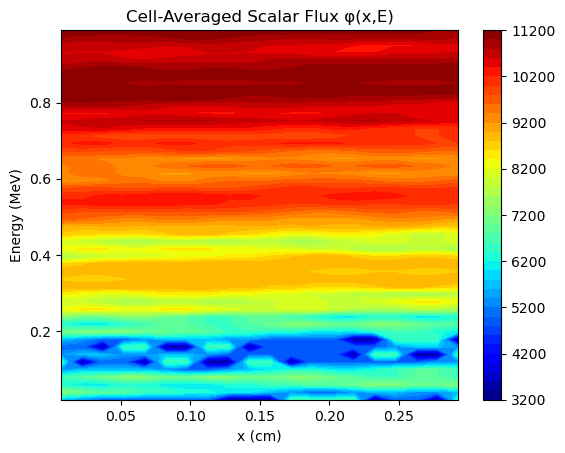

In [3]:
# 6. Parameter Definitions
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1.0   # 1 MeV initial energy
E_end = 0.01    # Lowest energy
N_ang = 8       
order = 1

# Create mesh and finite element space
mesh = mfem.Mesh(nx, nE, "QUADRILATERAL", True, 0.3, 1.0)
dim = mesh.Dimension()
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:", fes.GetTrueVSize())

# Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

# 7. Read Data and Define Material Coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, S_arr)  # Note: using -S_arr for S-coefficient
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff    = StoppingPowerCoefficient(-S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(-dS_dE_arr, E_start, E_end)

# 8. Set the Initial Total Flux (phi) to 1 everywhere.
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# 9. Source Iteration Parameters
max_iter = 20
tol = 1e-6
relax = 0.7  # Under-relaxation factor

# 10. Source Iteration Loop
for it in range(max_iter):
    print("\nSource iteration, iter =", it)
    psi_mu_list = []  # List to store (mu, weight, psi) for each angular direction
    
    # Angular sweep: Solve for each discrete angular direction
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for mu =", mu)
        # Create the velocity coefficient based on mu and S(E)
        v_coef = VelocityCoefficient(mu, S_coeff)
        
        # Set up the DG bilinear form A(.,.) for the transport equation
        a = mfem.BilinearForm(fes)
        a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
        a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
        a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
        a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.Assemble()
        a.Finalize()
        A = a.SpMat()
        
        # Set up the linear form b for the right-hand side.
        # It includes the boundary inflow condition and the scattering source (using old phi)
        b = mfem.LinearForm(fes)
        inflow_2d = Inflow2DCoefficient(1.0)
        b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
        scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
        b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
        b.Assemble()
        
        # Solve the system A * psi = b using MFEM's internal GMRES solver
        psi = mfem.GridFunction(fes)
        psi.Assign(1.0)  # initial guess
        prec = mfem.GSSmoother(A)
        solver = mfem.GMRESSolver()
        solver.SetOperator(A)
        solver.SetPreconditioner(prec)
        solver.SetRelTol(1e-12)
        solver.SetAbsTol(1e-12)
        solver.SetMaxIter(500)
        solver.SetKDim(30)
        solver.SetPrintLevel(0)
        solver.Mult(b, psi)
        print("    GMRES (mu =", mu, "): iterations =", solver.GetNumIterations(),
              "final norm =", solver.GetFinalNorm())
        
        # Enforce positivity: if any negative values occur in psi, set them to zero.
        for i in range(psi.Size()):
            if psi[i] < 0:
                psi[i] = 0.0

        
        # Append the angular solution for this mu once (avoid duplicate appending)
        psi_mu_list.append((mu, w, psi))
        
        # Optionally, save each angular solution and corresponding mesh.
        psi.Save("psi_mu_{:.3f}.gf".format(mu))
        mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))
    
    # Combine angular solutions to compute the scalar flux:
    # φ(x,E) = Σ_μ (w_μ * ψ(x,E,μ))
    phi_new = mfem.GridFunction(fes)
    phi_new.Assign(0.0)
    for mu, w, psi in psi_mu_list:
        phi_new.Add(w, psi)

    
    # Enforce positivity on the scalar flux as well.
    for i in range(phi_new.Size()):
        if phi_new[i] < 0:
            phi_new[i] = 0.0

    
    # Convergence check: compute the L2 norm of (phi_new - phi)
    diff_gf = mfem.GridFunction(fes)
    diff_gf.Assign(phi_new)
    diff_gf.Add(-1.0, phi)
    diff = diff_gf.Norml2()
    print("  Iteration difference (diff) =", diff)
    
    # Under-relaxation update: phi = relax * phi_new + (1-relax) * phi_old
    phi_temp = mfem.GridFunction(fes)
    phi_temp.Assign(phi_new)
    phi_temp.Add((1.0 - relax), phi)
    phi_temp *= relax
    phi.Assign(phi_temp)
    
    if diff < tol:
        print("Source iteration converged at iter =", it)
        break

# Save the final scalar flux φ to file.
phi.Save("psi_scalar.gf")
print("\nScalar flux saved to file: psi_scalar.gf")

# 11. Plot the Scalar Flux using matplotlib.
# Convert phi and mesh data into numpy arrays for plotting.
phi_arr = np.array([phi[i] for i in range(phi.Size())])
# Retrieve nodal coordinates from the mesh.
nodal_coords = np.array([[mesh.GetVertexArray()[i][0], mesh.GetVertexArray()[i][1]]
                           for i in range(mesh.GetNV())])


# --- Compute cell-averaged flux values
num_cells = mesh.GetNE()   # Expecting 1000 = 20*50 elements
cell_avg_2d = np.zeros((nE, nx))  # we will fill a (50 x 20) array

# We assume that elements are ordered row-major:
# Element 0 -> (iE=0, ix=0), Element 1 -> (iE=0, ix=1), ..., Element 19 -> (iE=0, ix=19),
# Element 20 -> (iE=1, ix=0), etc.
cell_counter = 0
for iE in range(nE):
    for ix in range(nx):
        # Get the list of DOF indices for the current element.
        dof_indices = fes.GetElementVDofs(cell_counter)
        # Compute the average value of phi over this cell.
        vals = [phi[i] for i in dof_indices]
        cell_avg_2d[iE, ix] = np.mean(vals)
        cell_counter += 1

# --- Determine cell center coordinates for plotting.
# The mesh file shows that vertices in x range from 0 to 0.3.
# Given nx cells, there are nx+1 nodes. Here we assume the nodes are equally spaced.
x_nodes = np.linspace(x_start, x_end, nx+1)
cell_x = 0.5 * (x_nodes[:-1] + x_nodes[1:])  # cell centers in x (length = nx)

# For energy, the vertices (y-coordinates) start at 1 (top row) and go to ~0.01.
# There will be nE+1 nodes. Use the same approach.
E_nodes = np.linspace(E_start, E_end, nE+1)
cell_E = 0.5 * (E_nodes[:-1] + E_nodes[1:])  # cell centers in energy (length = nE)

# Create a 2D meshgrid from the cell centers:
X, E_mesh = np.meshgrid(cell_x, cell_E)

# --- Plot the cell-averaged scalar flux.
plt.figure()
cp = plt.contourf(X, E_mesh, cell_avg_2d, levels=50, cmap='jet')
plt.colorbar(cp)
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Cell-Averaged Scalar Flux φ(x,E)")
# Invert the energy axis so that high energy (1 MeV) is at the top.
plt.show()



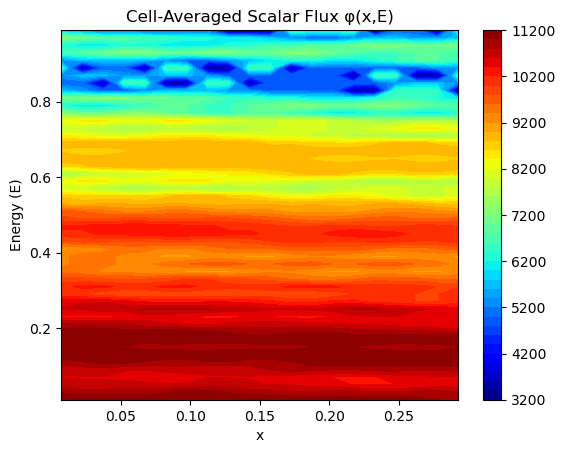

In [4]:
num_cells = mesh.GetNE()  
cell_avg_2d = np.zeros((nE, nx))  # We'll store averages in a (50 x 20) array.

# We assume that the elements are ordered in row-major order:
#   element 0 corresponds to (iE=0, ix=0),
#   element 1 -> (iE=0, ix=1),
#   ...,
#   element 19 -> (iE=0, ix=19),
#   element 20 -> (iE=1, ix=0), etc.
for iE in range(nE):
    for ix in range(nx):
        cell_index = iE * nx + ix
        # Get the list of DOF indices for the current element.
        dof_indices = fes.GetElementVDofs(cell_index)
        # Compute the average flux in this cell.
        vals = [phi[i] for i in dof_indices]
        cell_avg_2d[iE, ix] = np.mean(vals)

# --- 2. Compute Cell-Center Coordinates from Mesh Vertices ---
# Get the vertex coordinates from the mesh.
nv = mesh.GetNV()
nodal_coords = np.array([[mesh.GetVertexArray()[i][0], mesh.GetVertexArray()[i][1]]
                           for i in range(nv)])
# In your mesh, there are (nE+1)*(nx+1) vertices. For nx = 20 and nE = 50, that is 21*51 = 1071 vertices.
# Reshape the nodal coordinates into a (nE+1, nx+1, 2) array.
nodal_coords = nodal_coords.reshape((nE+1, nx+1, 2))
# Compute the cell centers as the average of the four vertices of each cell.
cell_centers = 0.25 * (nodal_coords[:-1, :-1, :] + nodal_coords[1:, :-1, :] +
                       nodal_coords[:-1, 1:, :] + nodal_coords[1:, 1:, :])
# Extract x and energy coordinates for cell centers.
X = cell_centers[:, :, 0]
E_mesh = cell_centers[:, :, 1]

# --- 3. Plot the Cell-Averaged Scalar Flux ---
plt.figure()
cp = plt.contourf(X, E_mesh, cell_avg_2d, levels=50, cmap='jet')
plt.colorbar(cp)
plt.xlabel("x")
plt.ylabel("Energy (E)")
plt.title("Cell-Averaged Scalar Flux φ(x,E)")
# Invert the energy axis so that high energy (1 MeV) appears at the top.

plt.show()

In [5]:
import numpy as np
import mfem.ser as mfem

def build_element_map(mesh, nx, ny, x_start, x_end, y_start, y_end):
    """
    Builds a mapping from each element in the mesh (as given by MFEM)
    to a user-defined (energy_index, x_index) pair.

    The function assumes that:
      - The physical domain in x is [x_start, x_end] with nx cells.
      - The physical domain in energy is [y_start, y_end] (with y_start > y_end)
        with ny cells. (y_start represents high energy.)
    
    For each element, the cell center is computed as the average of its vertex coordinates.
    Then, the (x_index, energy_index) is computed based on the cell center.
    
    Returns:
        A dictionary: element_map[e] = (iE, ix)
    """
    element_map = {}
    
    # Compute cell sizes
    cell_width = (x_end - x_start) / nx
    cell_height = (y_start - y_end) / ny  # because y_start > y_end
    
    # Loop over each element in the mesh
    for e in range(mesh.GetNE()):
        # Get the vertex indices for element e (MFEM returns a list-like object)
        vtx_ids = mesh.GetElementVertices(e)  # no extra argument needed
        
        # Collect coordinates for this element's vertices
        coords = []
        for vid in vtx_ids:
            vertex = mesh.GetVertexArray()[vid]
            coords.append((vertex[0], vertex[1]))
        
        # Compute the center of the element
        avg_x = np.mean([c[0] for c in coords])
        avg_y = np.mean([c[1] for c in coords])
        
        # Determine the x index (ix) and energy index (iE) for this cell.
        # For x, if avg_x is exactly x_start then ix = 0, and if avg_x is near x_end then ix = nx - 1.
        ix = int((avg_x - x_start) / cell_width)
        # For energy, because high energy is at y_start and decreases toward y_end,
        # if avg_y is near y_start then iE = 0, and if near y_end then iE = ny - 1.
        iE = int((y_start - avg_y) / cell_height)
        
        element_map[e] = (iE, ix)
    
    return element_map



element_map = build_element_map(mesh, nx, nE, x_start, x_end, E_start, E_end)

# Print out a few mappings for inspection
for e in range(5):
    print("Element", e, "-> (Energy index, x index):", element_map[e])


Element 0 -> (Energy index, x index): (50, 0)
Element 1 -> (Energy index, x index): (48, 0)
Element 2 -> (Energy index, x index): (47, 0)
Element 3 -> (Energy index, x index): (47, 1)
Element 4 -> (Energy index, x index): (48, 1)


In [72]:
mesh5 = mfem.Mesh(nx, nE, "QUADRILATERAL", True, 0.3, 0.99)
mesh5.Print("meshbes.mesh")
glvis(mesh5)

_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [70]:
'''
# This will be the init function:
nx = 20
nE = 50
x_start = 0.0
x_end = 0.3
E_start = 1.0
E_end = 0.01
N_ang = 8
order = 1


#mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
#dim = mesh.Dimension()

#fec = mfem.DG_FECollection(order, dim)
#fes = mfem.FiniteElementSpace(mesh, fec)

#ndofs = fes.GetVSize()
#print(f"Number of dimensions: {dim}")
#print(f"Number of finite element unknowns: {ndofs}")

#a = mfem.BilinearForm(fes)

#ess_tdof_list = mfem.intArray()
#dir_bdr = mfem.intArray(mesh.bdr_attributes.Max())
#dir_bdr.Assign(1)
#dir_bdr.Size()

#print(f"Number of finite element dir_bdr.Size(): {dir_bdr.Size()}")
#print(f"Number of finite element ess_tdof_list.Size(): {ess_tdof_list.Size()}")

#inflow_coeff = Inflow2DCoefficient(1.0)

# Read cross-section and stopping power data and compute necessary coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, -S_arr)
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff = StoppingPowerCoefficient(-S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

# Get Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

# Create a 2D mesh and finite element space (this remains fixed for all iterations)
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
#transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)
#transformer.Transform(mesh)
dim = mesh.Dimension()
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:", fes.GetTrueVSize())

# Initialize the total solution phi (scattering source) to 1 everywhere.
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 20
tol = 1e-6

# Start the source iteration loop
for iter in range(max_iter):
    print("Source iteration, iter =", iter)
    psi_mu_list = []  # To store tuples (mu, weight, psi) for each angular direction

    # Angular sweep: solve for each angular direction μ
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for μ =", mu)
        # Define the velocity coefficient v_coef depending on μ and S(E)
        v_coef = VelocityCoefficient(mu, S_coeff)

        # Set up the DG bilinear form a(.,.) on the fixed FE space.
        # The integrators include:
        # - A ConvectionIntegrator for the term: μ∂ψ/∂x + S(E)∂ψ/∂E
        # - Two MassIntegrators for the reaction term: [S'(E) + Σₜ(E)] ψ and for material interaction
        # - Face integrators for interior and boundary faces via NonconservativeDGTraceIntegrator.
        a = mfem.BilinearForm(fes)
        a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
        a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
        a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
        a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.Assemble()
        a.Finalize()

        # Set up the linear form b(·) for the right-hand side.
        # Here, we add the boundary inflow condition and a scattering source term.
        b = mfem.LinearForm(fes)
        inflow_2d = Inflow2DCoefficient(1.0)
        b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
        # Add scattering source: xs_s_coeff * φ (current source iterate)
        scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
        b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
        b.Assemble()

        # Solve the linear system Aψ = b using GMRES.
        A = a.SpMat()
        prec = mfem.GSSmoother(A)
        solver = mfem.GMRESSolver()
        solver.SetOperator(A)
        solver.SetPreconditioner(prec)
        solver.SetRelTol(1e-12)
        solver.SetAbsTol(1e-12)
        solver.SetMaxIter(500)
        solver.SetKDim(30)
        solver.SetPrintLevel(0)

        # Initialize the angular solution ψ for this μ.
        psi = mfem.GridFunction(fes)
        psi.Assign(1.0)
        solver.Mult(b, psi)
        print("    GMRES iterations (μ = {}):".format(mu), solver.GetNumIterations(), " final norm:", solver.GetFinalNorm())
        psi_mu_list.append((mu, w, psi))

    # Angular integration: compute the updated total solution φ_new(x,E) = Σ_μ w(μ) ψ(x,E,μ)
    phi_new = mfem.GridFunction(fes)
    phi_new.Assign(0.0)
    for mu, w, psi in psi_mu_list:
        phi_new.Add(w, psi)

    # Check convergence of the source iteration by computing the L2 norm of (phi_new - phi)
    diff_gf = mfem.GridFunction(fes)
    diff_gf.Assign(phi_new)
    diff_gf.Add(-1.0, phi)
    diff = diff_gf.Norml2()

    print("  Source iteration diff =", diff)
    if diff < tol:
        phi.Assign(phi_new)
        print("Source iteration converged.")
        break
    phi.Assign(phi_new)                
'''




'''
for mu, w in zip(mu_vals, w_vals):
    print("Solving for μ =", mu)
    # Create a 2D mesh over [0,L] x [E_min,E_max] using quadrilaterals.
    mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
    #transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)
    #transformer.Transform(mesh)
    dim = mesh.Dimension()
    order = 2

    # Define the DG finite element space using L2 elements
    fec = mfem.L2_FECollection(order, dim)
    fes = mfem.FiniteElementSpace(mesh, fec)
    print("Number of unknowns:", fes.GetTrueVSize())
    v_coef = VelocityCoefficient(mu, S_coeff)

    # Set up the bilinear form a(.,.) for the DG formulation.
    a = mfem.BilinearForm(fes)
    # Volume integrator for convection term: μ ∂ψ/∂x + S(E) ∂ψ/∂E.
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
    # Mass integrators for the reaction term: [S'(E) + Σₜ(E)] ψ.
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
    a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
    a.Assemble()
    a.Finalize()
    
    b = mfem.LinearForm(fes)
    inflow_2d = Inflow2DCoefficient(1.0)
    q_coef = QCoefficient(0)
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coef))
    b.Assemble()

    # Solve the linear system using GMRES
    A = a.SpMat()
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(1)

    # Initialize the solution GridFunction
    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)
    solver.Mult(b, psi)
    print("GMRES iterations (μ = {}):".format(mu), solver.GetNumIterations(), " final norm:", solver.GetFinalNorm())
    # Save the solution for this angular direction and store in list
    psi_mu_list.append((mu, psi))
    out_name = f"psi_mu_{mu:.3f}.gf"
    psi.Save(out_name)
    print(f"Solution for μ = {mu:.3f} saved to {out_name}.\n")

    
# Angular integration: compute total solution phi(x,E) = Σ_{μ} w(μ) ψ(x,E,μ)

phi = mfem.GridFunction(fes)
phi.Assign(0.0)
for mu, psi in psi_mu_list:
    weight = w_vals[mu_vals.index(mu)]
    phi.Add(weight, psi)
out_total = "phi.gf"
phi.Save(out_total)
print("Angle-integrated solution saved to", out_total)
# Save the mesh for GLVis visualization
mesh.Print("mesh.mesh")
print("Mesh saved to mesh.mesh")


#---------------------------------------------------
# GLVis Visualization
#---------------------------------------------------
# Visualize the total (angle-integrated) solution with GLVis.
# The title is set to "Total Angular Flux" and we wait for 500 ms.
glvis(mesh, phi, "Total Angular Flux", 500)
#---------------------------------------------------
# Dose Calculation and Plotting (Matplotlib)
#---------------------------------------------------
# Here, we compute the average flux in the energy (y) direction for each x cell,
# then define dose as the normalized flux relative to the value at x=0.
x_coords = []
avg_flux = []
for i in range(nx):
    # x coordinate of the cell center
    x_val = x_start + (x_end - x_start)*(i + 0.5)/ nx
    cell_vals = []
    for j in range(ny):
        # y (energy) coordinate of the cell center
        y_val = E_start + (E_end - E_start)*(j + 0.5) / nE
        # Compute cell index in row-major order
        cell_index = i * nE + j
        cell_vals.append(phi[cell_index])
    x_coords.append(x_val)
    avg_flux.append(np.mean(cell_vals))
avg_flux = np.array(avg_flux)
# Define dose as the normalized average flux (dose at x divided by dose at x=0)
dose = avg_flux / avg_flux[0]
# Plot the average flux along x
plt.figure()
plt.plot(x_coords, avg_flux, 'o-', label='Average Flux')
plt.xlabel("x (cm)")
plt.ylabel("Average Angular Flux ψ(x)")
plt.title("Average Angular Flux vs. x")
plt.grid(True)
plt.legend()
# Plot the computed dose profile
plt.figure()
plt.plot(x_coords, dose, 's-', color='red', label='Dose (Normalized)')
plt.xlabel("x (cm)")
plt.ylabel("Dose (normalized)")
plt.title("Dose Profile vs. x")
plt.grid(True)
plt.legend()
plt.show()


'''


'\nfor mu, w in zip(mu_vals, w_vals):\n    print("Solving for μ =", mu)\n    # Create a 2D mesh over [0,L] x [E_min,E_max] using quadrilaterals.\n    mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)\n    #transformer = MeshTransformer2D(x_start, x_end, E_start, E_end)\n    #transformer.Transform(mesh)\n    dim = mesh.Dimension()\n    order = 2\n\n    # Define the DG finite element space using L2 elements\n    fec = mfem.L2_FECollection(order, dim)\n    fes = mfem.FiniteElementSpace(mesh, fec)\n    print("Number of unknowns:", fes.GetTrueVSize())\n    v_coef = VelocityCoefficient(mu, S_coeff)\n\n    # Set up the bilinear form a(.,.) for the DG formulation.\n    a = mfem.BilinearForm(fes)\n    # Volume integrator for convection term: μ ∂ψ/∂x + S(E) ∂ψ/∂E.\n    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))\n    # Mass integrators for the reaction term: [S\'(E) + Σₜ(E)] ψ.\n    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))\n    a.AddDomainIntegrator(mfem.M

In [71]:
def create_3D_mesh(nx, ny, nz, x_start, x_end, y_start, y_end, z_start, z_end):
    """
    Creates a 3D mesh with specified intervals and coordinate ranges.

    Args:
        nx (int): Number of intervals in the x-direction.
        ny (int): Number of intervals in the y-direction.
        nz (int): Number of intervals in the z-direction.
        x_start (float): Starting x-coordinate.
        x_end (float): Ending x-coordinate.
        y_start (float): Starting y-coordinate.
        y_end (float): Ending y-coordinate.
        z_start (float): Starting z-coordinate.
        z_end (float): Ending z-coordinate.

    Returns:
        mesh: The updated 3D mesh with vertex coordinates set accordingly.
    """
    # Generate equally spaced coordinates for x, y, and z
    x_coords = np.linspace(x_start, x_end, nx + 1)
    y_coords = np.linspace(y_start, y_end, ny + 1)
    z_coords = np.linspace(z_start, z_end, nz + 1)
    
    # Create the 3D mesh with initial x, y, z values set to 0
    mesh = mfem.Mesh(nx, ny, nz, "HEXAHEDRON", True, 0.0, 0.0, 0.0)
    
    # Retrieve the vertex array from the mesh
    verts = mesh.GetVertexArray()
    
    # Expected number of vertices: (nx+1) * (ny+1) * (nz+1)
    expected_num = (nx + 1) * (ny + 1) * (nz + 1)
    num_verts = mesh.GetNV()
    if num_verts != expected_num:
        print("Warning: Unexpected number of vertices! ({} != {})".format(num_verts, expected_num))
    
    # Update the vertex coordinates; vertices are stored in order: x changes fastest, then y, then z.
    k = 0
    for k_z in range(nz + 1):
        for k_y in range(ny + 1):
            for k_x in range(nx + 1):
                verts[k][0] = x_coords[k_x]
                verts[k][1] = y_coords[k_y]
                verts[k][2] = z_coords[k_z]
                k += 1
    
    # Define the target directory and file name
    target_dir = os.path.join(os.getcwd(), 'mesh', 'usr')
    file_name = f'{nx}x{ny}_3D.mesh'
    file_path = os.path.join(target_dir, file_name)
    
    # Check if the target directory exists; if not, create it
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Directory '{target_dir}' was created.")

    # Check if the file already exists
    if not os.path.exists(file_path):
        # If the file does not exist, write the mesh to the file
        mesh.Print(file_path)
        print(f"File '{file_path}' was successfully created.")
    else:
        print(f"File '{file_path}' already exists.")

    return mesh

In [72]:
glvis(mesh, 900, 900)

_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [73]:
mesh1 = create_3D_mesh(20, 20, 50, 0, 1, 0, 1, 1, 0.01)
glvis(mesh1, 900, 900)

File '/Users/melekderman/github/BFP/examples/mesh/usr/20x20_3D.mesh' already exists.


_GlvisWidgetCore(data_str='mesh\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POINT   …

In [35]:
'''# Initialize parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1.0
E_end = 0.01
N_ang = 8       
order = 1

'''# Infinite medium problem coefficients
dS_dE_coeff = np.zeros(nE)
S_coeff = np.zeros(nE)
inflow_coeff = Inflow2DCoefficient(2.0)
xs_t_arr = np.ones(nE) * 2
xs_s_arr = np.zeros(nE)
S_arr = np.zeros(nE)
q_arr = np.ones(nE) * 8
'''
# Get Gauss-Legendre angular quadrature points and weights
mu_vals, w_vals = gauss_legendre_dirs(N_ang)

# Read cross-section and stopping power data, then compute necessary coefficients
E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)
dS_dE_arr = compute_S_derivative(E_arr, S_arr)
xs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)
xs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)
S_coeff = StoppingPowerCoefficient(S_arr, E_start, E_end)
dS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)

# Create a 2D mesh and finite element space (this remains fixed for all iterations)
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
print("Number of unknowns:", fes.GetTrueVSize())

# Project each coefficient onto the finite element space and save as grid functions.
gf_xs_t = mfem.GridFunction(fes)
gf_xs_t.ProjectCoefficient(xs_t_coeff)
gf_xs_t.Save("xs_t_coeff.gf")
print("Total cross-section coefficient saved to xs_t_coeff.gf")

gf_xs_s = mfem.GridFunction(fes)
gf_xs_s.ProjectCoefficient(xs_s_coeff)
gf_xs_s.Save("xs_s_coeff.gf")
print("Scattering cross-section coefficient saved to xs_s_coeff.gf")

gf_S = mfem.GridFunction(fes)
gf_S.ProjectCoefficient(S_coeff)
gf_S.Save("S_coeff.gf")
print("Stopping power coefficient saved to S_coeff.gf")

# Initialize the total solution (scattering source) phi to 1 everywhere.
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

# Source iteration parameters
max_iter = 20
tol = 1e-6

# Start the source iteration loop
for iter in range(max_iter):
    print("Source iteration, iter =", iter)
    psi_mu_list = []  # To store tuples (mu, weight, psi) for each angular direction

    # Angular sweep: solve for each angular direction μ
    for mu, w in zip(mu_vals, w_vals):
        print("  Solving for μ =", mu)
        # Define the velocity coefficient based on μ and S(E)
        v_coef = VelocityCoefficient(mu, S_coeff)

        # Set up the DG bilinear form a(.,.) on the fixed FE space.
        # The integrators include:
        # - ConvectionIntegrator for the term: μ∂ψ/∂x + S(E)∂ψ/∂E
        # - MassIntegrators for the reaction term: [S'(E) + Σₜ(E)]ψ and for material interaction
        # - NonconservativeDGTraceIntegrator for interior and boundary faces.
        a = mfem.BilinearForm(fes)
        a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
        a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
        a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
        a.AddInteriorFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.AddBdrFaceIntegrator(mfem.NonconservativeDGTraceIntegrator(v_coef, 1.0))
        a.Assemble()
        a.Finalize()

        # Set up the linear form b(·) for the right-hand side.
        # Add the boundary inflow condition and the scattering source term.
        b = mfem.LinearForm(fes)
        inflow_2d = Inflow2DCoefficient(1.0)
        b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_2d, v_coef, 1.0))
        scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
        b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
        b.Assemble()

        # Solve the linear system A ψ = b using GMRES.
        A = a.SpMat()
        prec = mfem.GSSmoother(A)
        solver = mfem.GMRESSolver()
        solver.SetOperator(A)
        solver.SetPreconditioner(prec)
        solver.SetRelTol(1e-12)
        solver.SetAbsTol(1e-12)
        solver.SetMaxIter(500)
        solver.SetKDim(30)
        solver.SetPrintLevel(0)

        # Initialize the angular solution ψ for this μ.
        psi = mfem.GridFunction(fes)
        psi.Assign(1.0)
        solver.Mult(b, psi)
        print("    GMRES iterations (μ = {}):".format(mu),
              solver.GetNumIterations(), "final norm:", solver.GetFinalNorm())

        # Append the result to the list (for each discrete ordinate)
        psi_copy = mfem.GridFunction(fes)
        psi_copy.Assign(psi)
        psi_mu_list.append((mu, w, psi_copy))


        # Optional: Save each angular solution and corresponding mesh to separate files
        psi.Save("psi_mu_{:.3f}.gf".format(mu))
        mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))

        # --- Combining the Results ---
        # Compute the scalar (angle-integrated) flux: ψ(x,E) = Σ_μ (w_μ * ψ_μ(x,E))
        psi_copy = mfem.GridFunction(fes)
        psi_copy.Assign(psi)
        psi_mu_list.append((mu, w, psi_copy))
    
        psi_copy.Assign(0.0)
        for (mu, w, psi_mu) in psi_mu_list:
            psi_copy.Add(w, psi_mu)
        psi_copy.Save("psi_scalar.gf")
        print("Scalar flux saved to file: psi_scalar.gf")
    
        # Update the total solution φ: φ_new(x,E) = Σ_μ w(μ) ψ(x,E,μ)
        phi_new = mfem.GridFunction(fes)
        phi_new.Assign(0.0)
        for mu, w, psi in psi_mu_list:
            phi_new.Add(w, psi)
    
        # Check convergence of the source iteration by computing the L2 norm of (φ_new - φ)
        diff_gf = mfem.GridFunction(fes)
        diff_gf.Assign(phi_new)
        diff_gf.Add(-1.0, phi)
        diff = diff_gf.Norml2()
        print("  Source iteration diff =", diff)
        if diff < tol:
            phi.Assign(phi_new)
            print("phi_new =", phi)
        print("Source iteration converged at iter =", iter)
        phi.Assign(phi_new)
'''

'\n# Get Gauss-Legendre angular quadrature points and weights\nmu_vals, w_vals = gauss_legendre_dirs(N_ang)\n\n# Read cross-section and stopping power data, then compute necessary coefficients\nE_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr = read_data(50)\ndS_dE_arr = compute_S_derivative(E_arr, S_arr)\nxs_t_coeff = TotalXSCoefficient(xs_t_arr, E_start, E_end)\nxs_s_coeff = ScatteringXSCoefficient(xs_s_arr, E_start, E_end)\nS_coeff = StoppingPowerCoefficient(S_arr, E_start, E_end)\ndS_dE_coeff = StoppingPowerDerivativeCoefficient(dS_dE_arr, E_start, E_end)\n\n# Create a 2D mesh and finite element space (this remains fixed for all iterations)\nmesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)\ndim = mesh.Dimension()\nfec = mfem.L2_FECollection(order, dim)\nfes = mfem.FiniteElementSpace(mesh, fec)\nprint("Number of unknowns:", fes.GetTrueVSize())\n\n# Project each coefficient onto the finite element space and save as grid functions.\ngf_xs_t = mfem.GridFunction(fes)\ngf_xs_t.P